# Defining morphological neuron models with `neat.PhysTree`
The Class `neat.PhysTree` is used to define the physiological parameters of neuron models. It inherits from `neat.MorphTree` and thus has all its functionality. Just as `neat.MorphTree`, instances are initialized based on the standard `.swc` format:

In [1]:
from neat import PhysTree
ph_tree = PhysTree(file_n='morph/L23PyrBranco.swc')

## Defining physiological parameters

A `PhysTree` consists of `neat.PhysNode` instances, which inherit from `neat.MorphNode`. Compared to a `MorphNode`, a `PhysNode` has extra attributes (initialized to some default value) defining physiological parameters:

In [2]:
# specific membrance capacitance (uF/cm^2)
print('default c_m node 1:', ph_tree[1].c_m)
# axial resisitance (MOhm*cm)
print('default r_a node 1:', ph_tree[1].r_a)
# point-like shunt located at {'node': node.index, 'x': 1.} (uS)
print('default g_shunt node 1:', ph_tree[1].g_shunt)
# leak and ion channel currents, stored in a dict with
# key: 'channel_name', value: [g_max, e_rev]
print('default currents node 1:', ph_tree[1].currents)

default c_m node 1: 1.0
default r_a node 1: 0.0001
default g_shunt node 1: 0.0
default currents node 1: {}


It is not recommended, and for ion channels even forbidden, to set the parameters directly via the nodes. Rather, the parameters should be specified with associated functions of `PhysTree`. These functions accept a `node_arg` keyword argument, which allows selecting a specific set of nodes. Parameters, can be given as `float`, in which case all nodes in `node_arg` will be set to the same value, a `dict` of `{node.index: parameter_value}`, or a callable function where the input is the distance of the middle of the node (`loc = {'node': node.index, 'x': .5}`) to the soma and the output the parameter.

Let's use `PhysTree.setPhysiology()` to set capacitance (1st argument) and axial resistance (2nd argument) in the whole tree:

In [3]:
ph_tree.setPhysiology(lambda x: .8 if x < 60. else 1.6*.8, 100.*1e-6)

Here, we defined the capacitance to be $.8$ $\mu$F/cm$^2$ when the mid-point of the node is less than 60 $\mu$m from the soma and $1.6*.8$ $\mu$F/cm$^2$, a common factor to take dendritic spines into account. Axial resistance was set to a constant value throughout the tree.

To set ion channels (see the 'Ionchannels in NEAT' tutorial on how to create your own ion channels), we must create the ion channel instance first. Here, we'll set a default sodium and potassium channel:

In [4]:
from neat.channels.channelcollection.channelcollection import Na_Ta, Kv3_1
# create the ion channel instances
na_chan = Na_Ta()
k_chan = Kv3_1()
# set the sodium channel only at the soma, with a reversal of 50 mV
ph_tree.addCurrent(na_chan, 1.71*1e6, 50., node_arg=[ph_tree[1]])
# set the potassium channel throughout the dendritic tree, at 1/10th 
# of its somatic conductance, and with a reversal of -85 mV
gk_soma = 0.45*1e6
ph_tree.addCurrent(k_chan, lambda x: gk_soma if x < .1 else gk_soma/10., -85.)

Now, we only have to set the leak current. We have two possibilities for this: (i) we could set the leak current by providing conductance and reversal in the standard way with `PhysTree.setLeakCurrent()` or (ii) with could fit the leak current to fix equilibrium potential and membrane time scale (if possible) with `PhysTree.fitLeakCurrent()`. We take the second option here:

In [5]:
# fit leak current to yield an equilibrium potential of -70 mV and
# a total membrane time-scale of 10 ms (with channel opening 
# probabilities evaluated at -70 mV)
ph_tree.fitLeakCurrent(-70., 10.)

## Inspecting the physiological parameters

We can now inspect the contents of various `PhysNode` instances:

In [6]:
# soma node
print(ph_tree[1])

SNode 1 --- (r_a = 9.999999999999999e-05 MOhm*cm, g_Na_Ta = 1710000.0 uS/cm^2, g_Kv3_1 = 450000.0 uS/cm^2, g_L = 31.54081073184777 uS/cm^2, c_m = 0.8 uF/cm^2)


In [7]:
# dendrite node
print(ph_tree[115])

SNode 115, Parent: SNode 114 --- (r_a = 9.999999999999999e-05 MOhm*cm, g_Kv3_1 = 45000.0 uS/cm^2, g_L = 123.19344287327351 uS/cm^2, c_m = 1.2800000000000002 uF/cm^2)


Or, to get the full information on conductances and reversal potentials of membrane currents:

In [8]:
# soma node
print(ph_tree[1].currents)

{'Na_Ta': [1710000.0, 50.0], 'Kv3_1': [450000.0, -85.0], 'L': (31.54081073184777, -48.638804987272536)}


In [9]:
# dendrite node
print(ph_tree[115].currents)

{'Kv3_1': [45000.0, -85.0], 'L': (123.19344287327351, -69.41475491536458)}


## Active dendrites compared to closest passive version

Imagine we aim to investigate the role of active dendritic channels, and to that purpose want to compare the active dendritic tree with a passive version. We may compute the leak conductance of this "passified" tree as the sum of all ion channel conductance evaluate at the equilibrium potential. The equilibrium potentials is stored on the tree using `PhysTree.setEEq()`:

In [10]:
ph_tree.setEEq(-70.)

To obtain the passified tree, we use `PhysTree.asPassiveMembrane()`. However, this function will overwrite the parameters of the original nodes, if we want to maintain the initial tree, we have to copy it first:

In [11]:
# copy the initial tree
ph_tree_pas = ph_tree.__copy__()
# set to (except the soma)
ph_tree_pas.asPassiveMembrane([n for n in ph_tree_pas if n.index != 1])

We can now inspect the nodes:

In [12]:
# soma node
print(ph_tree_pas[1])

SNode 1 --- (r_a = 9.999999999999999e-05 MOhm*cm, g_Na_Ta = 1710000.0 uS/cm^2, g_Kv3_1 = 450000.0 uS/cm^2, g_L = 31.54081073184777 uS/cm^2, c_m = 0.8 uF/cm^2)


In [13]:
# dendrite node
print(ph_tree_pas[115])

SNode 115, Parent: SNode 114 --- (r_a = 9.999999999999999e-05 MOhm*cm, g_L = 128.0 uS/cm^2, c_m = 1.2800000000000002 uF/cm^2)


And the currents:

In [14]:
# soma node
print(ph_tree_pas[1].currents)

{'Na_Ta': [1710000.0, 50.0], 'Kv3_1': [450000.0, -85.0], 'L': (31.54081073184777, -48.638804987272536)}


In [15]:
# dendrite node
print(ph_tree_pas[115].currents)

{'L': (128.0, -70.0)}


Comparing this to the previously shown nodes of the full tree, we see that the dendrite nodes have been "passified".

## Computational tree

The computational tree in `PhysTree` works the same as in `MorphTree`, except that it's derivation also considers changes in physiological parameters, next to changes in morphological parameters.

In [16]:
ph_tree.setCompTree()
# compare number of nodes in computational tree and original tree
ph_tree.treetype = 'original'
print('%d nodes in original tree'%(len(ph_tree)))
ph_tree.treetype = 'computational'
print('%d nodes in computational tree'%(len(ph_tree)))

432 nodes in original tree
98 nodes in computational tree


Compare this to the number of nodes in the computational tree induced solely by the morphological parameters:

In [17]:
from neat import MorphTree
m_tree = MorphTree('morph/L23PyrBranco.swc')
m_tree.setCompTree()
m_tree.treetype = 'computational'
print('%d nodes in computational `MorphTree`'%len(m_tree))

87 nodes in computational `MorphTree`


Note: only call this `PhysTree.setCompTree` when all physiological parameters have been set, and ***never*** change parameters stored at individual nodes when `treetype` is ``computational``, as this leads to the computational tree being inconsistent with the original tree.

# Simulating NEAT-defined neuron models with `neat.NeuronSimTree`

NEAT implements an interface to the NEURON simulator, so that models defined by neat-trees can be simulated with the NEURON simulator. To have access to this functionality, the NEURON simulator and it's Python interface need to be installed.

The class `neat.NeuronSimTree` implements this interface, and inherits from `neat.PhysTree`. Hence, a `NeuronSimTree` can be defined in the same way as a `PhysTree`.

In [18]:
from neat import NeuronSimTree
sim_tree = NeuronSimTree(file_n='morph/L23PyrBranco.swc')
sim_tree.setPhysiology(lambda x: .8 if x < 60. else 1.6*.8, 100.*1e-6)
# ... etc

## The `__copy__` function

If a different type of tree is needed than the one originality defined, a handy feature of NEAT's copy function can be used: we can specify the type of tree we want as a keyword argument to `neat.MorphTree.__copy__()`. This function then copies all attributes that both tree classes have in common. Since `NeuronSimTree` is a subclass of `PhysTree`, we end up with an identical tree, but with additional functions and associated attributes to simulate the associated NEURON model.

In [33]:
sim_tree = ph_tree.__copy__(new_tree=NeuronSimTree())

## Setting up a simulation

First, we must initialize the tree structure into hoc.

In [34]:
sim_tree.initModel(t_calibrate=100.)

We may then add inputs to the tree. NEAT implements a number of standard synapse types and current injections. Let's apply a DC current step to the soma and also give some input to a conductance-based dendritic synapse.

In [35]:
# somatic DC current step with amplitude = 0.100 nA, delay = 5. ms and duration = 50. ms
sim_tree.addIClamp((1.,.5), 0.010, 5., 50.)
# dendritic synapse with rise resp. decay times of .2 resp 3. ms and reversal of 0 mV
sim_tree.addDoubleExpSynapse((115,.8), .2, 3., 0.)
# give the dendritic synapse a weight of 0.005 uS and connect it to an input spike train
sim_tree.setSpikeTrain(0, 0.005, [20.,22.,28.,29.,30.])

We will record voltage at the somatic and dendritic site. Recording locations should be stored under the name 'rec locs'.

In [36]:
sim_tree.storeLocs([(1,.5), (115,.8)], name='rec locs')

We can then run the model for $60$ ms and plot the results:

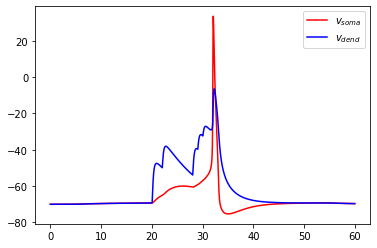

In [39]:
# simulate the model
res = sim_tree.run(60.)

# plot the results
import matplotlib.pyplot as pl
pl.plot(res['t'], res['v_m'][0], c='r', label=r'$v_{soma}$')
pl.plot(res['t'], res['v_m'][1], c='b', label=r'$v_{dend}$')
pl.legend(loc=0)
pl.show()

## User defined point-process

Note that it is very easy to add user defined point-process to the `NeuronSimTree`. In fact, all any of the default functions to add point-process do, is defining a `neat.MorphLoc` based on the input, so that the point process is added at the right coordinates no matter whether `treetype` was 'original' or 'computational'. All hoc sections are stored in the dict `self.sections` which has as keys the node indices. Hence, in pseudo code one would do:

```
loc = neat.MorphLoc((node.index, x-coordinate), sim_tree)

# define the point process at the correct location
pp = h.user_defined_point_process(sim_tree.sections[loc['node']](loc['x']))

# set its parameters
pp.param1 = val1
pp.param2 = val2
...

# store the point process (e.g. if it is a synapse in `sim_tree.syns`)
sim_tree.syns.append(pp)
```